In [89]:
import copy
import datetime as dt
from pathlib import Path
import warnings

import holidays
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.mode.chained_assignment = None  # default='warn'
matplotlib.rcParams.update({'font.size': 15})
warnings.simplefilter("ignore")

In [90]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"

train = pd.read_csv(DATA_PATH / "train.csv")

In [91]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


## Data Distribution

Leveraging sales data from 2017 to 2021, our objective is to develop a predictive model to forecast 'num_sold' for the forthcoming year, 2022. This predictive modeling hinges on a thorough grasp of four key components: date, country, store, and the specific product category. Consequently, our initial step involves a methodical analysis of the correlation between 'num_sold' and each of these four variables.

In [92]:
# explore unique column entries
unique_values = {}
columns = ["country", "store", "product"]

for column in columns:
    unique_values[column] = train[column].unique()
    print(f"Unique entires in {column}:\n{unique_values[column]}\n")

Unique entires in country:
['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain']

Unique entires in store:
['Kaggle Learn' 'Kaggle Store' 'Kagglazon']

Unique entires in product:
['Using LLMs to Improve Your Coding' 'Using LLMs to Train More LLMs'
 'Using LLMs to Win Friends and Influence People'
 'Using LLMs to Win More Kaggle Competitions' 'Using LLMs to Write Better']



In [93]:
# Creating variables for analysis
analysis = train.drop(columns='id')
# date column is separated for each element
analysis['date'] = pd.to_datetime(analysis['date'])
analysis['day'] = analysis['date'].dt.day
analysis['week'] = analysis['date'].dt.dayofweek
analysis['month'] = analysis['date'].dt.month
analysis['year'] = analysis['date'].dt.year
analysis['day_of_year'] = analysis['date'].dt.dayofyear
analysis['time_no'] = (
    analysis['date'] - dt.datetime(2017, 1, 1)) // dt.timedelta(days=1)
analysis.loc[analysis['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1
date_columns = ['date', 'day', 'week', 'month', 'year', 'time_no']

### Plots - Store

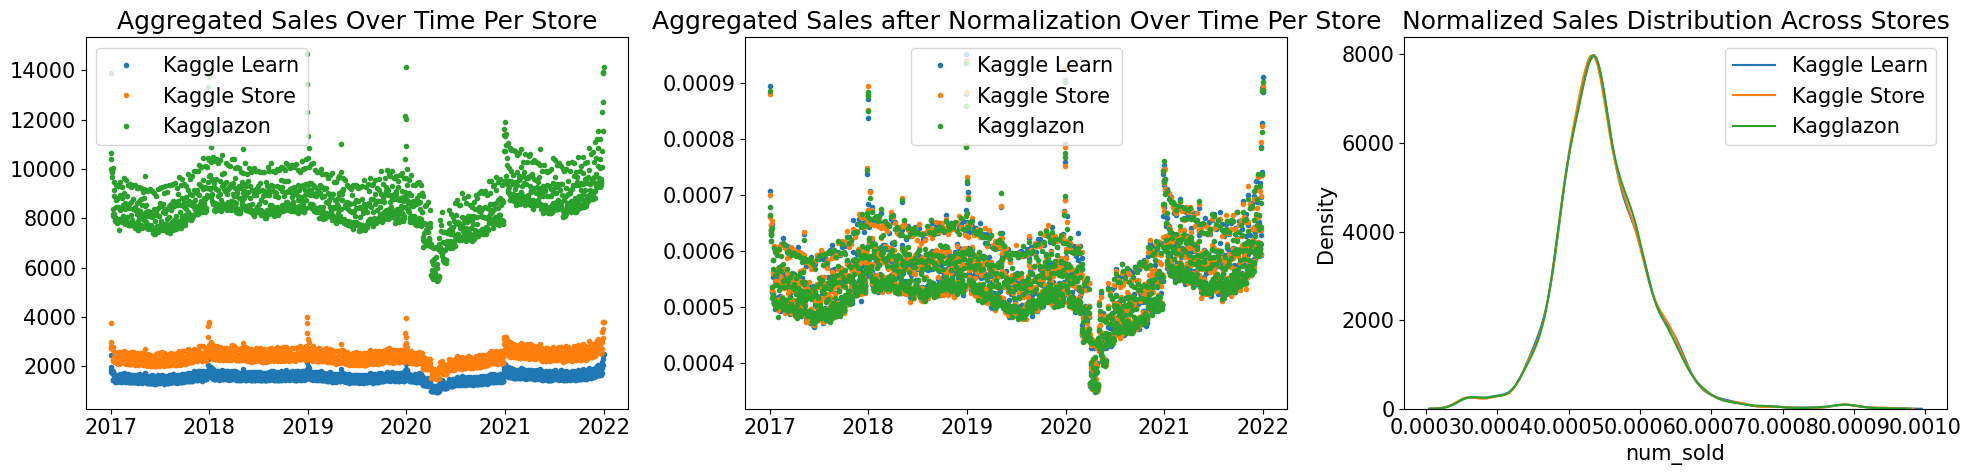

In [96]:
# ----Store----

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
grouped_data = analysis.groupby(['date', 'store'])['num_sold'].sum().reset_index()

# First plot
for store in unique_values["store"]:
    store_data = grouped_data[grouped_data['store'] == store]
    axs[0].plot(store_data['date'], store_data['num_sold'], ".", label=store)
axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Store')

# Second plot
for store in unique_values["store"]:
    store_data = grouped_data[grouped_data['store'] == store]
    axs[1].plot(store_data['date'], store_data['num_sold'] /
             store_data['num_sold'].sum(), ".", label=store)
axs[1].legend()
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Store')

# Third plot
for store in unique_values["store"]:
    store_data = grouped_data[grouped_data['store'] == store]['num_sold']
    sum_store=store_data.sum()
    axs[2] = sns.kdeplot(store_data/sum_store, label=store, ax=axs[2])
axs[2].legend()
axs[2].set_title('Normalized Sales Distribution Across Stores')

plt.tight_layout()
plt.show()

After analyzing the retail outlets, it's evident that they showcase comparable sales distributions, varying only by a scalar factor. This trend becomes noticeable when standardizing the sales of each store by its overall sales and comparing the resulting distributions, as depicted earlier.

### Plots - Country

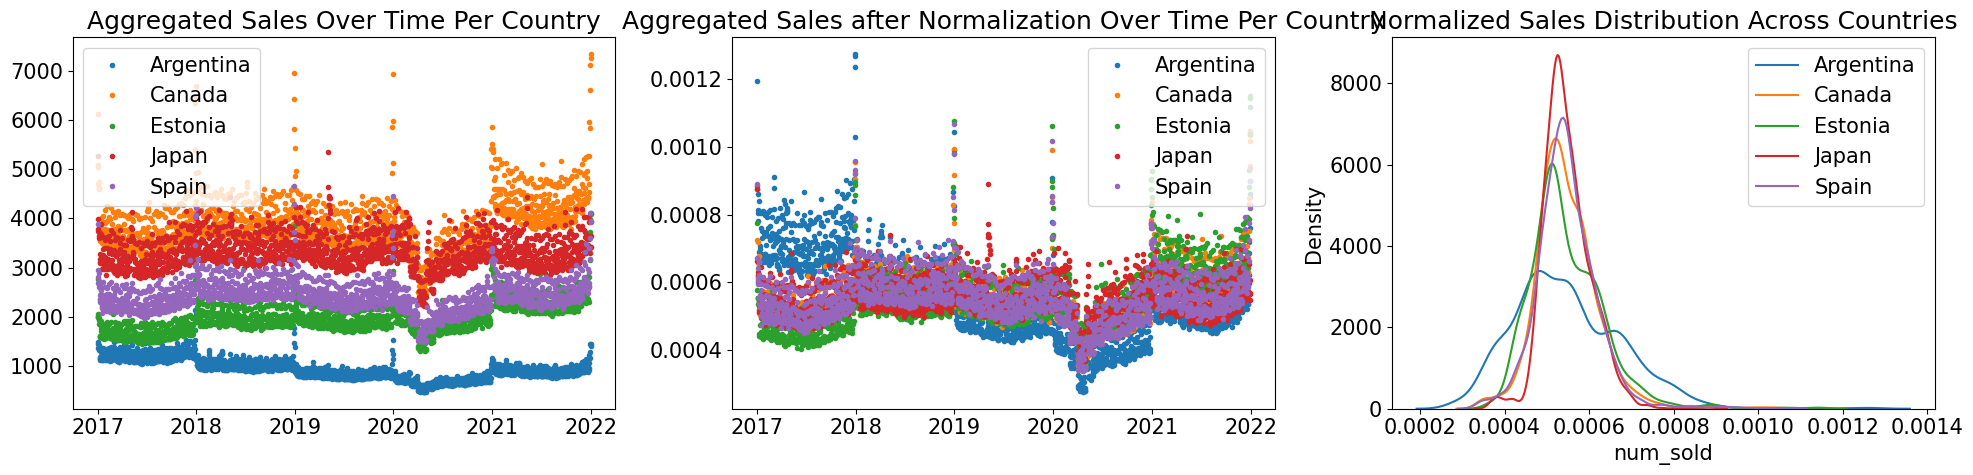

In [95]:
# ----Country----

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
grouped_data_country = analysis.groupby(['date', 'country'])['num_sold'].sum().reset_index()

# First plot
for country in unique_values["country"]:
    country_data = grouped_data_country[grouped_data_country['country'] == country]
    axs[0].plot(country_data['date'], country_data['num_sold'], ".", label=country)
axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Country')

# Second plot
for country in unique_values["country"]:
    country_data = grouped_data_country[grouped_data_country['country'] == country]
    axs[1].plot(country_data['date'], country_data['num_sold']/country_data['num_sold'].sum(), ".", label=country)
axs[1].legend()
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Country')

# Third plot
for country in unique_values["country"]:
    country_data = grouped_data_country[grouped_data_country['country']== country]
    sum_country = country_data['num_sold'].sum()
    axs[2] = sns.kdeplot(country_data['num_sold']/sum_country, label=country)
axs[2].legend()
axs[2].set_title('Normalized Sales Distribution Across Countries')
plt.tight_layout()
plt.show()

Our analysis has unveiled valuable insights:

There's a noticeable disparity in 'num_sold' across various years, indicating significant changes in sales volume from year to year.
Within each year, 'num_sold' follows a consistent pattern across different countries, although the extent of change between years varies by country.
Based on these findings, we propose one approach for our prediction model:

Trend-Based Projection:
We can assume that sales in 2022 will follow a similar trend to that of 2021. By adjusting the 'num_sold' values for each year to align with the 2021 levels, we aim to utilize this adjusted data for more accurate sales predictions in 2022.

This approach offers us a valuable strategy to refine our predictive model and optimize sales forecasts for the upcoming year, 2022.

In [101]:
# ----refinement of changes between years----
df = analysis.groupby(['date', 'country'], as_index=False).mean(numeric_only = True)
df_not_outlier = df.copy()
df_not_outlier = df_not_outlier.loc[df_not_outlier['month'].isin([1,2])]
df_not_outlier = df_not_outlier.loc[(df_not_outlier['month'] == 2) | (df_not_outlier['day'] >= 11)]
df_not_outlier = df_not_outlier.loc[(df_not_outlier['month'] == 1) | (df_not_outlier['day'] <= 14)]
change = df_not_outlier.groupby(['country', 'year'], as_index=False).mean()
change = change[['country', 'year', 'num_sold']]

for year in [2017,2018,2019,2020,2021]:
    df = pd.merge(df, change.loc[change['year']==year].rename(columns={'num_sold':f'c{year}'}).drop(columns='year'),
                  on=['country'])
df.loc[df['year'] == 2017, 'num_sold'] /= df['c2017']
df.loc[df['year'] == 2018, 'num_sold'] /= df['c2018']
df.loc[df['year'] == 2019, 'num_sold'] /= df['c2019']
df.loc[df['year'] == 2020, 'num_sold'] /= df['c2020']
df.loc[df['year'] <2021, 'num_sold'] *= df['c2021']

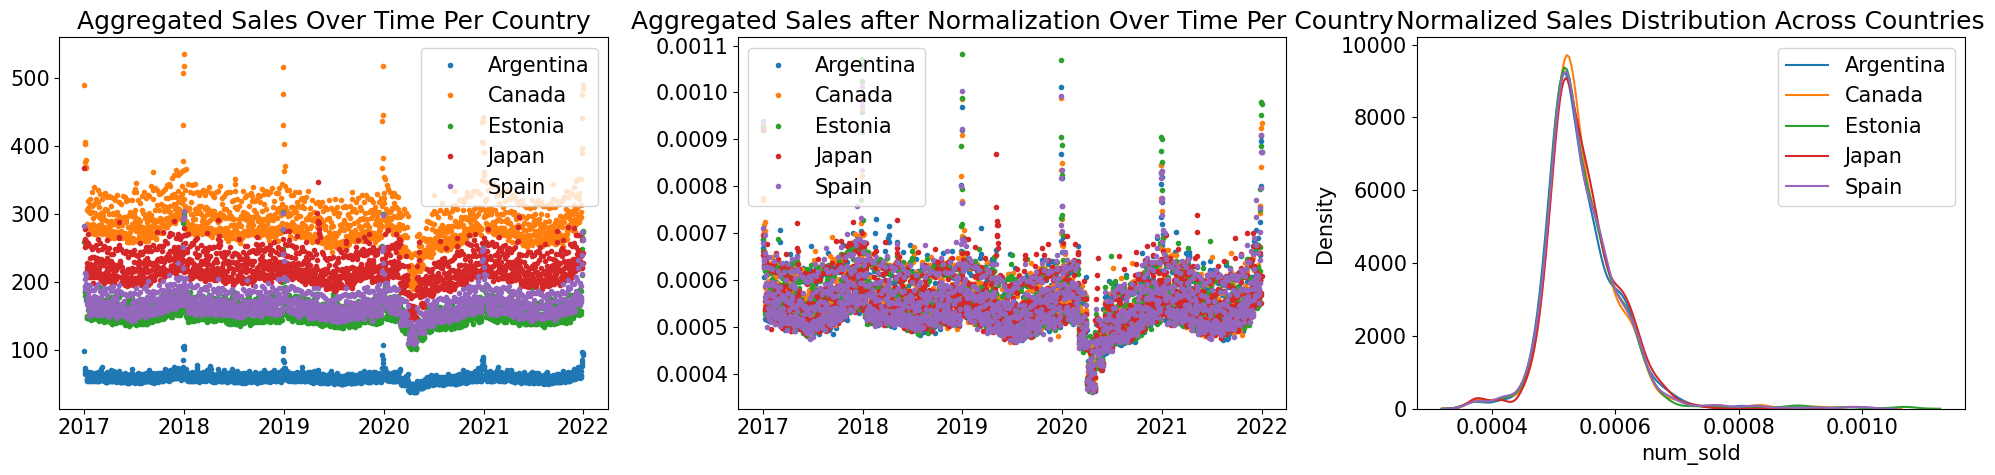

In [102]:
# ----refinements of changes between years----
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for country in analysis.country.unique():
    country_data = df[df['country'] == country]
    axs[0].plot(country_data['date'], country_data['num_sold'], ".", label=country)
axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Country')

# Second plot
for country in analysis.country.unique():
    country_data = df[df['country'] == country]
    axs[1].plot(country_data['date'], country_data['num_sold']/country_data['num_sold'].sum(), ".", label=country)
axs[1].legend()
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Country')

# Third plot
for country in analysis.country.unique():
    country_data = df[df['country'] == country]
    axs[2] = sns.kdeplot(country_data['num_sold']/country_data['num_sold'].sum(), label=country)
axs[2].legend()
axs[2].set_title('Normalized Sales Distribution Across Countries')
plt.tight_layout()
plt.show()

Above we've normalized the sales data from 2017 to 2020 to the 2021 level by adjusting for the average annual sales for each country. Specifically, we use the data duing Jan.11th- February (no holiday) for each year and calculate the mean value for each country. Then num_sold is normalized by using this mean value. We see that the normalized data has the same distribution for different countries.

### Plots - Product

Text(0.5, 1.0, 'Aggregated Sales after Normalization Over Time Per Product')

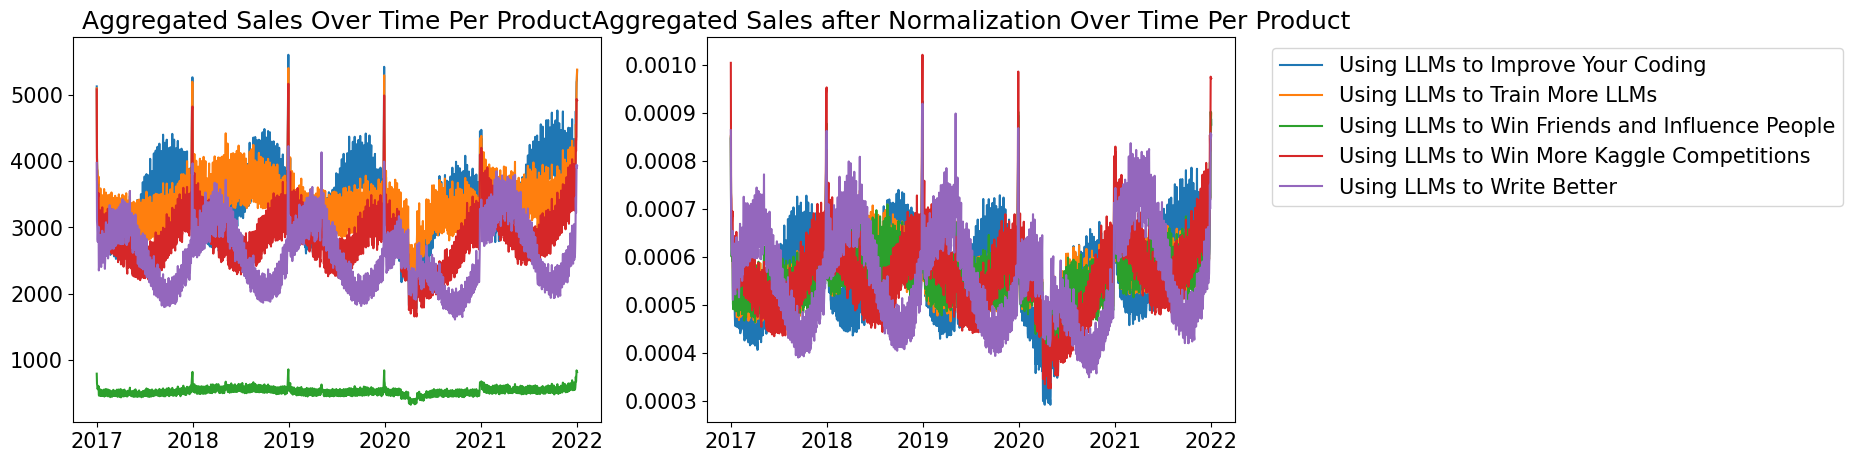

In [107]:
# ----product----

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

grouped_data = analysis.groupby(['date', 'country','product'])['num_sold'].sum().reset_index()
grouped_data['num_sold'] = grouped_data['num_sold']
grouped_data = grouped_data.groupby(['date','product'])['num_sold'].sum().reset_index()

# First plot
for product in analysis["product"].unique():
    product_data = grouped_data[grouped_data['product'] == product]
    axs[0].plot(product_data['date'], product_data['num_sold'],label=product)
#axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Product')


grouped_data = analysis.groupby(['date', 'product'])['num_sold'].sum().reset_index()
for product in analysis["product"].unique():
    product_data = grouped_data[grouped_data['product'] == product]
    axs[1].plot(product_data['date'], product_data['num_sold']/product_data['num_sold'].sum(),label=product)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Product')

In every product, we notice that the sales trend displays both sine and cosine components, suggesting a cyclical pattern. However, the amplitudes of these cyclical components differ across various products. Therefore, we'll analyze each product individually.

Additionally, noticeable sales peaks coincide with holiday seasons.

It's important to note that the year 2020 stands out due to the impact of COVID-19, 
resulting in a deviation from typical sales patterns.

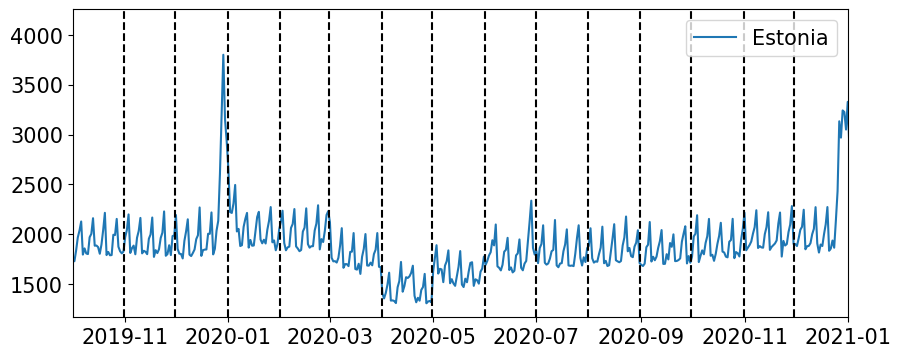

In [108]:
# ----check covid----

df_check = analysis.groupby(['date', 'country'])[['num_sold']].sum().reset_index()

fig = plt.figure(figsize=(10, 4))
for i, country in enumerate(analysis.country.unique()[2:3]):
    X = df_check[df_check['country'] == country]
    plt.plot(X['date'], X['num_sold'], label=country)
    plt.legend()
    plt.xlim([dt.date(2019, 10, 1), dt.date(2021, 1, 1)])
    for i in range(10, 13):
        datetime1 = dt.datetime(2019, i, 1) - dt.timedelta(days=1)
        datetime2 = dt.datetime(2019, i, 1)
        mid_datetime = datetime1 + (datetime2 - datetime1) / 2
        plt.axvline(mid_datetime, color='k', linestyle='--')
    for i in range(1, 13):
        datetime1 = dt.datetime(2020, i, 1) - dt.timedelta(days=1)
        datetime2 = dt.datetime(2020, i, 1)
        mid_datetime = datetime1 + (datetime2 - datetime1) / 2
        plt.axvline(mid_datetime, color='k', linestyle='--')


We can see that covid acts monthly.

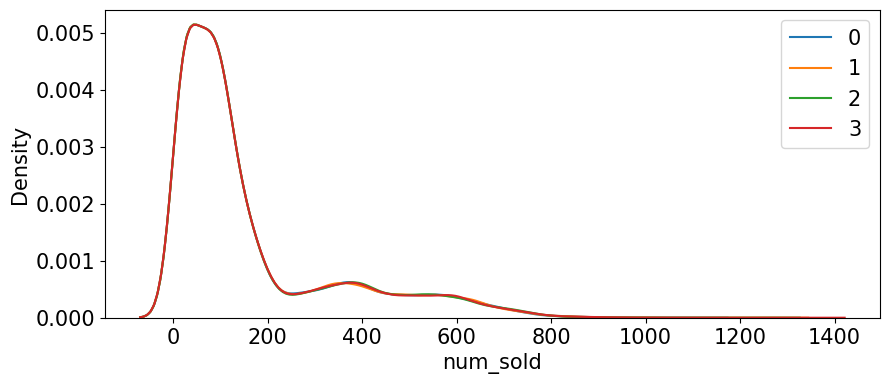

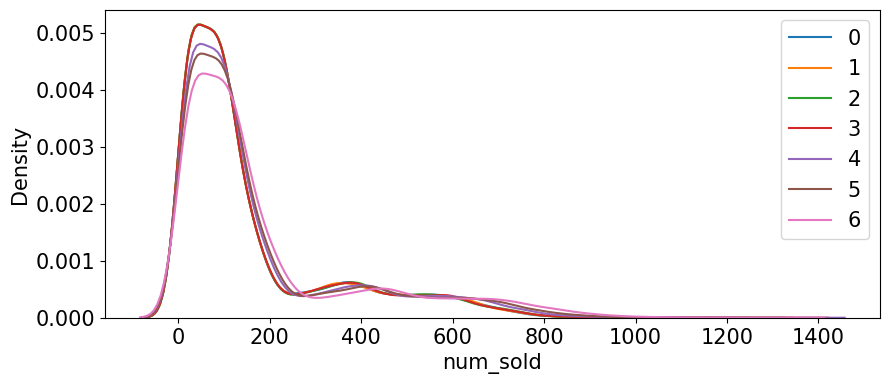

In [88]:
fig = plt.figure(figsize=(10, 4))
for w in [0,1,2,3]:
    w_data = analysis[analysis['week'] == w]['num_sold']
    sns.kdeplot(w_data, label=w)
plt.legend()
plt.show()
fig = plt.figure(figsize=(10, 4))
for w in [0, 1, 2, 3,4,5,6]:
    w_data = analysis[analysis['week'] == w]['num_sold']
    sns.kdeplot(w_data, label=w)
plt.legend()
plt.show()

We see that the distribution of Monday-Thursday are the same, while Firday-Sunday are different.

